In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


from IPython.display import display

_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees Assignment

## Part 1: House Price Regression

Apply decision trees to the Ames housing dataset you've worked with this week!

- Try multiple features
- Try features you've engineered
- Try different `max_depth` paramaters
- What's the best Test Root Mean Squared Error you can get? *Share with your cohort on Slack!*
- What's a cool visualization you can make? *Share with your cohort on Slack!*

In [0]:
#paste code from prev assignments w/ Ames housing data:

url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'

df = pd.read_csv(url)

#columns to drop bc of NaNs:
drop_cols = ['Alley', 'Fence', 'MiscFeature']
df = df.drop(columns = drop_cols)

#Fill Nans for garage yr blt w/ YearBlt value:
nums = df[df.GarageYrBlt.isna() == True].index
for i in nums:
  df.at[i, 'GarageYrBlt'] = df.at[i, 'YearBuilt']
  
#drop 8 rows of masonry veneer area Nans:
df.dropna(subset=['MasVnrArea'], inplace=True)

#replace most of the categoricals with numbers:
map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.NaN: 0}
df = df.replace(map)

#Fill NaNs for LotFrontage as 0:
#df['LotFrontage'] = df['LotFrontage'].fillna(0)

#create log price column
df['ln_price'] = np.log(df['SalePrice'])

#age:
df['age'] = 2010 - df['YearBuilt']

#renovation_age:
df['renovation_age'] = 2010 - df['YearRemodAdd']

#yard size (ignores deck, pool, etc):
df['yard_size'] = df['LotArea'] - df['1stFlrSF']

#garage finish:
finish_map = {'Fin':3, 'RFn': 2, 'Unf':1, np.NaN:0}
df['GarageFinish'] = df['GarageFinish'].replace(finish_map)

#sale condition:
sale_map = {'Normal': 3,
            'Partial': 3,
            'Abnorml': 1,
            'Family': 1,
            'AdjLand': 2,	
            'Alloca': 2}

df['SaleCondition'] = df['SaleCondition'].replace(sale_map)

#Lot shape:
shape_map = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}
df["LotShape"] = df["LotShape"].replace(shape_map)

#Street:
street_map = {'Grvl':1, 'Pave':2}
df['Street'] = df['Street'].replace(street_map)

#Neighborhood Quality:
neighborhood_qual_map = dict(df.groupby('Neighborhood', as_index=False)['OverallQual'].mean().set_index('Neighborhood')['OverallQual'])
df['neighborhood_qual']= df['Neighborhood'].map(neighborhood_qual_map)

#Neighborhood avg Sales price:
neighborhood_sales_map = dict(df.groupby('Neighborhood', as_index=False)['SalePrice'].mean().set_index('Neighborhood')['SalePrice'])
df['neighborhood_avg_sale_price'] = df['Neighborhood'].map(neighborhood_sales_map)

#Neighborhood avg log_Sales price:
neighborhood_ln_sales_map = dict(df.groupby('Neighborhood', as_index=False)['ln_price'].mean().set_index('Neighborhood')['ln_price'])
df['neighborhood_avg_ln_sale_price'] = df['Neighborhood'].map(neighborhood_ln_sales_map)


In [0]:
def run_linear_model(X, y):
    # Split into test and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

    # Fit model using train data
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions using test features
    y_pred = model.predict(X_test)

    # Compare predictions to test target
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)

    print('Root Mean Squared Error', rmse)
    print('R^2 Score', r2)
    print('Intercept', model.intercept_)
    coefficients = pd.Series(model.coef_, X_train.columns)
    print(coefficients.to_string())

In [0]:
def run_decision_tree(X, y, max_depth_list, min_samples_list):
   # Split into test and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

    for i in max_depth_list:
      for j in min_samples_list:
        max_depth = i
        min_samples_split = j 
        
        # Fit model using train data
        tree = DecisionTreeRegressor(max_depth=i, min_samples_split=j)
        tree.fit(X_train, y_train)
    
        # Make predictions using test features
        y_pred = tree.predict(X_test)
    
        # Compare predictions to test target
        print('max_depth: ' + str(max_depth))
        print('min samples split: ' + str(min_samples_split))
        
        # The mean squared error
        print("Mean squared error: " + str(mean_squared_error(y_test, y_pred)))
        
        # R2: Explained variance score
        print('Test Variance score: ' + str(r2_score(y_test, y_pred)))

    

In [6]:
max_depths = [5, 10, 50, 500]
min_samples = [2, 5, 25, 100]

X = df.select_dtypes(include='number').drop(columns = ['SalePrice', 'ln_price'])
y = df.ln_price

run_decision_tree(X, y, max_depths, min_samples)

max_depth: 5
min samples split: 2
Mean squared error: 0.03643280512299566
Test Variance score: 0.7802860808064912
max_depth: 5
min samples split: 5
Mean squared error: 0.036086121145944526
Test Variance score: 0.7823768145576352
max_depth: 5
min samples split: 25
Mean squared error: 0.035301944370909784
Test Variance score: 0.7871059193301541
max_depth: 5
min samples split: 100
Mean squared error: 0.03548385034173665
Test Variance score: 0.7860089059752904
max_depth: 10
min samples split: 2
Mean squared error: 0.04491945157726201
Test Variance score: 0.7291059878385842
max_depth: 10
min samples split: 5
Mean squared error: 0.043785813528238494
Test Variance score: 0.735942575300268
max_depth: 10
min samples split: 25
Mean squared error: 0.0383061963529127
Test Variance score: 0.7689882922360465
max_depth: 10
min samples split: 100
Mean squared error: 0.03467212939107198
Test Variance score: 0.790904120350355
max_depth: 50
min samples split: 2
Mean squared error: 0.046576708679716944
Te

In [7]:
run_linear_model(X,y)

Root Mean Squared Error 0.12908690247133606
R^2 Score 0.8995085021224939
Intercept 17.928654184214412
Id                               -1.387482e-05
MSSubClass                       -5.305129e-04
LotFrontage                      -1.853416e-04
LotArea                           3.192831e-05
Street                            2.828720e-02
LotShape                          1.119236e-02
OverallQual                       6.276330e-02
OverallCond                       4.169075e-02
YearBuilt                         8.472496e-04
YearRemodAdd                      2.478910e-04
MasVnrArea                       -1.105621e-05
ExterQual                         8.000647e-03
ExterCond                        -1.781248e-02
BsmtQual                          2.782892e-02
BsmtCond                          2.459273e-02
BsmtFinSF1                        1.197661e-05
BsmtFinSF2                       -1.005198e-05
BsmtUnfSF                        -1.890573e-05
TotalBsmtSF                      -1.698110e-05
Heati

## Part 2 / Stretch: "Play Tennis" Classification

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

#### "Table 1 shows a small training set"

In [8]:
columns = 'No. Outlook Temperature Humidity Windy PlayTennis'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]
tennis = pd.DataFrame(data=data, columns=columns).set_index('No.')
tennis['PlayTennis'] = (tennis['PlayTennis'] == 'P').astype(int)

tennis

,Outlook,Temperature,Humidity,Windy,PlayTennis
No.,,,,,
1,sunny,hot,high,false,0
2,sunny,hot,high,true,0
3,overcast,hot,high,false,1
4,rain,mild,high,false,1
5,rain,cool,normal,false,1
6,rain,cool,normal,true,0
7,overcast,cool,normal,true,1
8,sunny,mild,high,false,0
9,sunny,cool,normal,false,1


#### "A decision tree that correctly classifies each object in the training set is given in Figure 2."

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

In this dataset, the tennis player decided to play on 64% of the days, and decided not to on 36% of the days.

In [9]:
tennis['PlayTennis'].value_counts(normalize=True) * 100

1    64.285714
0    35.714286
Name: PlayTennis, dtype: float64

The tennis player played on 100% of the overcast days, 40% of the sunny days, and 60% of the  rainy days

In [10]:
tennis.groupby('Outlook')['PlayTennis'].mean() * 100

Outlook
overcast    100.0
rain         60.0
sunny        40.0
Name: PlayTennis, dtype: float64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [11]:
sunny = tennis[tennis['Outlook']=='sunny']
sunny.groupby('Humidity')['PlayTennis'].mean() * 100

Humidity
high        0
normal    100
Name: PlayTennis, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [12]:
rainy = tennis[tennis['Outlook']=='rain']
rainy.groupby('Windy')['PlayTennis'].mean() * 100

Windy
false    100
true       0
Name: PlayTennis, dtype: int64

#### Before modeling, we will ["encode" categorical variables, using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=get_dummies#computing-indicator-dummy-variables)

In [0]:
y = tennis['PlayTennis']
X = pd.get_dummies(tennis.drop(columns='PlayTennis'))

In [14]:
X.head()

,Outlook_overcast,Outlook_rain,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_false,Windy_true
No.,,,,,,,,,,
1,0,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,1,1,0,1,0
5,0,1,0,1,0,0,0,1,1,0


## Train a Decision Tree Classifier
Get a score of 100% (accuracy)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [15]:
max_depths = [2,5,10]
min_samples = [2,3,5]

run_decision_tree(X, y, max_depth_list = max_depths, min_samples_list=min_samples)

max_depth: 2
min samples split: 2
Mean squared error: 0.20833333333333334
Test Variance score: 0.06250000000000011
max_depth: 2
min samples split: 3
Mean squared error: 0.041666666666666664
Test Variance score: 0.8125
max_depth: 2
min samples split: 5
Mean squared error: 0.041666666666666664
Test Variance score: 0.8125
max_depth: 5
min samples split: 2
Mean squared error: 0.0
Test Variance score: 1.0
max_depth: 5
min samples split: 3
Mean squared error: 0.16666666666666666
Test Variance score: 0.2500000000000001
max_depth: 5
min samples split: 5
Mean squared error: 0.041666666666666664
Test Variance score: 0.8125
max_depth: 10
min samples split: 2
Mean squared error: 0.3333333333333333
Test Variance score: -0.4999999999999998
max_depth: 10
min samples split: 3
Mean squared error: 0.0
Test Variance score: 1.0
max_depth: 10
min samples split: 5
Mean squared error: 0.041666666666666664
Test Variance score: 0.8125


In [20]:
#looks like we get 100% acccuracy w/ max_depth of 5 and min_samples_split of 2:

tree = DecisionTreeRegressor(max_depth=5, min_samples_split=2)
tree.fit(X, y)
tree.score(X, y)

1.0

## Compare to Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [23]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X, y)
logistic.score(X, y)

0.8571428571428571

## Visualize the tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

In [24]:
!pip install graphviz 

In [25]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [0]:
import graphviz

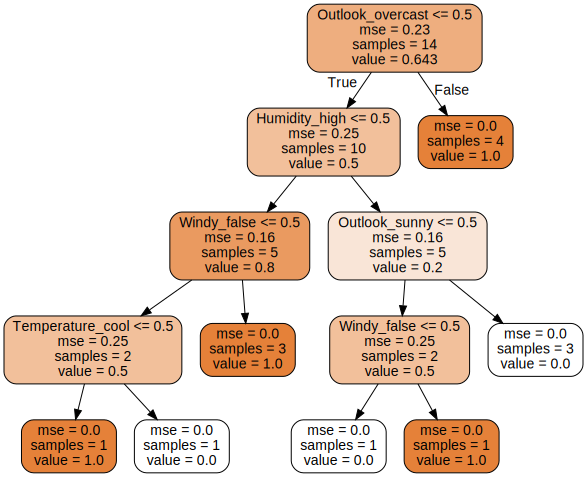

In [30]:
def viztree(decision_tree, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)
  
display(viztree(tree, feature_names=X.columns))